<a href="https://colab.research.google.com/github/ericlrf/vc/blob/main/aula_11_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Codigo da aula 10 com alguns trechos adicionados a partir de slides da aula 11

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.data import AUTOTUNE
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam

In [5]:
# /content/drive/MyDrive/Colab Notebooks/vc/data
def main():
  batch_size = 50
  img_height = 64
  img_width = 64

  train_ds = image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/vc/data/train',
                                          seed=123,
                                          image_size=(img_height, img_width),
                                          batch_size=batch_size)
  
  val_ds = image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/vc/data/test',
                                          seed=123,
                                          image_size=(img_height, img_width),
                                          batch_size=batch_size)
  
  print(train_ds.class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  num_classes = 15

  # ##################################################
  # data_augmentation = keras.Sequential([
  #                                       layers.experimental.prepocessing.RandomFlip("horizontal",
  #                                                                                   input_shape=(img_height,
  #                                                                                                img_width,
  #                                                                                                3)),
  # ])
  # ##################################################
  data_augmentation = keras.Sequential([
                                        layers.experimental.preprocessing.RandomFlip("horizontal"),
  ])
  # ##################################################
  base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                           include_top=False,
                           weights='imagenet')
  
  base_model.trainable = False
  
  global_average_layer = layers.GlobalAveragePooling2D()
  prediction_layer = layers.Dense(num_classes)
  
  inputs = Input(shape=(img_height, img_width, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = layers.Dropout(0.5)(x)
  outputs = prediction_layer(x)
  model = Model(inputs, outputs)
  # ##################################################################
  # model = Sequential([
  #     data_augmentation,
  #     layers.experimental.preprocessing.Rescaling(1./255),
  #     layers.Conv2D(16, 3, padding='same', activation='relu'),
  #     layers.MaxPooling2D(),
  #     layers.Conv2D(32, 3, padding='same', activation='relu'),
  #     layers.MaxPooling2D(),
  #     layers.Conv2D(64, 3, padding='same', activation='relu'),
  #     layers.MaxPooling2D(),
  #     layers.Dropout(0.5),
  #     layers.Flatten(),
  #     layers.Dense(128, activation='relu'),
  #     layers.Dense(num_classes)
  # ])
  # ##################################################################
  model.compile(optimizer='adam',
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  model.summary()

  epochs=100
  history = model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=epochs)
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8,8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

  # ##############################################################
  base_model.trainable = True

  fine_tune_at = 100

  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  model.compile(optimizer=Adam(0.0001),
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
  model.summary()

  history_fine = model.fit(train_ds,
                           epochs=200,
                           initial_epoch=history.epoch[-1],
                           validation_data=val_ds)
  
  acc+= history_fine.history['accuracy']
  val_acc += history_fine.history['val_accuracy']

  loss+= history_fine.history['loss']
  val_loss += history_fine.history['val_loss']

  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.plot([99,99], plt.ylim(), label='Start Fine Tunning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.plot([99,99], plt.ylim(), label='Start Fine Tunning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

  # #########################################
  img = load_img('/content/drive/MyDrive/Colab Notebooks/vc/data/test/Bedroom/image_0003.jpg',
                 target_size=(img_height, img_width))
  img_array = img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  print(predictions)

Found 1500 files belonging to 15 classes.
Found 2985 files belonging to 15 classes.
['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'InsideCity', 'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry', 'Store', 'Street', 'Suburb', 'TallBuilding']
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 64, 64, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984

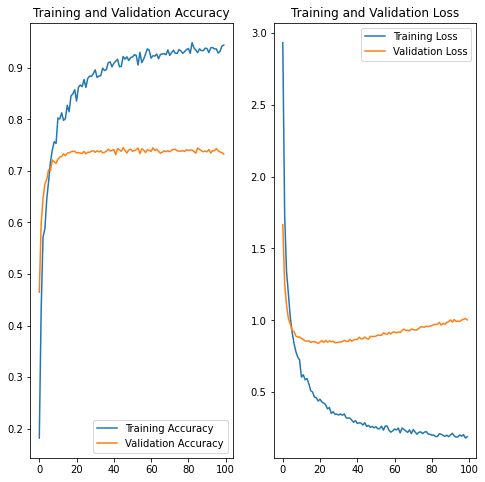

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 64, 64, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

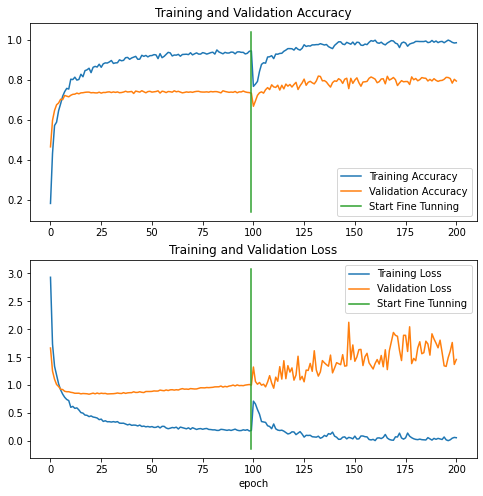

[[  4.3810596 -19.59066   -27.335718  -24.443556   -9.997213  -23.329643
   -8.810377   13.565465  -14.464377  -10.908555  -20.580263  -16.497349
  -16.791801   -7.023802  -11.78511  ]]


In [6]:
if __name__ == '__main__':
  main()

In [ ]:
# [[  4.3810596  -19.59066   -27.335718  -24.443556   -9.997213  -23.329643
#    -8.810377   13.565465  -14.464377  -10.908555  -20.580263  -16.497349
#   -16.791801   -7.023802  -11.78511  ]]

In [ ]:
# ['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'InsideCity', 
#  'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry', 'Store', 
#  'Street', 'Suburb', 'TallBuilding']